# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Rohan, Prajwal  
**Release date**: 05/03/21  
**Submission date** : 16/03/21

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 
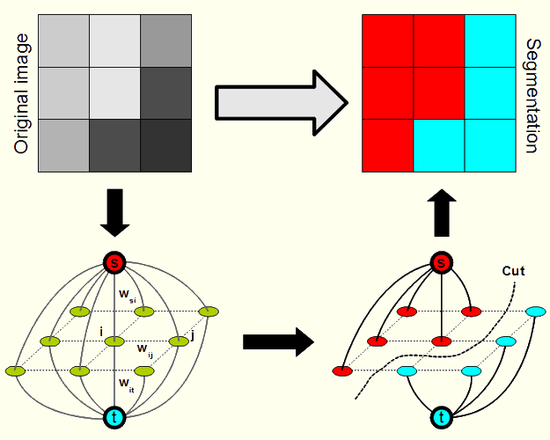

The code below takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links
* https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf

In [1]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [18]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : BGD}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : FGD}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img2 = img.copy()
    
    mask = np.ones(img.shape[:2]) * BGD  # mask is a binary array with : 0 - background pixels
    master_mask = mask.copy()
        
    output = np.zeros(img.shape, np.uint8)                 # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img2, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        cv2.imshow('Segmented image', output)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#

            mask = mask.copy()
            
            if FLAGS['RECT']:
                y, x, height, width = FLAGS['RECT']
                print(x, y, height, width)
            
                mask[x:x+width, y:y+height] = PR_FGD
            
            plt.imshow(mask)            
            plt.title("Initial Mask")
            plt.show()

            mask = grabcut(img2, mask)
            EventObj.mask = mask

            FLAGS['RECT'] = None
            EventObj.flags = FLAGS
            
            mask_ = mask.copy()
            mask_[np.logical_or(mask == PR_FGD, mask == FGD)] = 1
            mask_[np.logical_or(mask == PR_BGD, mask == BGD)] = 0
            master_mask = mask_.copy()
            output = cv2.bitwise_and(img2, img2, mask = mask_.astype("uint8"))
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.bitwise_and(img, img, mask = master_mask.astype("uint8")))
    plt.title("Final Segmentation")
    plt.show()

The task here is to segment the foreground and the background in an image, given a rough bounding box as a hint. This is done using the Grabcut algorithm, which is implemented as follows:

1. User draws a bounding box which contains the foreground object.
    1. Everything outside this box is classified as BGD (firm background), everything inside as PR_FGD (probably foreground). PR_BGD will represent the probably background. These two make up the unknown pixels of our image.
2. Initialize background and foreground Gaussian Mixture Models with the initialised mask.
3. Assign components to pixels
4. Estimate Segmentation using Min-cut
5. Repeat from step 2 until convergence.

The segmentation is estimated using min-cut:
1. The image is considered to be a graph, with each pixel connected to its neighbours (8-connected here).
2. Each pixel is also connected to a source, and sink node (representing connection to foreground or background).
    1. Edge weights here are based on the score of the sample with respect to its GMM. 
    2. The nodes that we are sure of have a high weight assigned to it from S/T, indicating that it should not be cut.
3. We find a minimum cut from source to sink that can partition the pixels into two sets. The edge weights add constraints about which region it should belong to, and how various pixels should be in agreement with each other.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import igraph
import time

In [4]:
from sklearn.mixture import GaussianMixture

In [34]:
GAMMA = 50

In [6]:
BGD = 0
FGD = 1
PR_FGD = 0.5
PR_BGD = -0.5

$\beta$ is calculated as $$\frac{1}{2*avg((z_m - z_n)^2)}$$

This parameter is also involved in the smoothness of the image.

In [9]:
def calc_beta(img):
    
    beta = 0
    count = 0
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            color = img[i][j]
            trans = [(0, -1), (-1, -1), (-1, 0), (-1, 1)]
            
            for x, y in trans:
                
                if i+x < 0 or j+y < 0:
                    continue
                    
                try:
                    diff = img[i][j] - img[i+x][j+y]
                    beta += diff.T @ diff
                    count += 1
                except:
                    pass
        
    avg = beta/count
    return 1 / (2 * avg)

There are two weights used in this problem - unary potential and binary potential. Unary potential is for the edges connected to S/T while binary potential refers to the edges connecting various pixels.

The unary potential is calculated as:

$$-\log\pi(\alpha_n, k_n) + \frac{1}{2}\det\Sigma(\alpha_n, k_n) + \frac{1}{2}[z_n - \mu(\alpha_n, k_n)]^T\Sigma[z_n - \mu(\alpha_n, k_n)]$$

The binary potential is calculated as:

$$\gamma e^{-\beta \vert\vert z_m - z_n \vert\vert^2}$$, where $\beta$ is defined earlier.

The unary potential is used for edges S-x and T-x while binary potential is for the eight-connected graph. The total energy of the system is the sum of unary and binary potential of all pixels.

In [38]:
def get_weight(pixels, gmm):
    scores = -gmm.score_samples(pixels)
    return scores

def get_binary_weights(pixel_1, pixel_2, beta):
    diff = pixel_2 - pixel_1
    return GAMMA * np.exp(-beta * (diff.T @ diff))

We define a graph using igraph here with the source as S - representing the foreground and T - representing the background. The pixels are all connected to S and T with weights set as defined in the Boykov and Jolly paper. The weights for the unknown region and binary potential are defined as shown in the previous cell.

In [10]:
"""
For S or T, assign weights based on the Gaussian Mixture model of
foreground or background respectively.
"""
def create_X_weights(img, gmm):
    weights = get_weight(img.reshape(-1, 3), gmm).reshape((img.shape[0], img.shape[1]))    
    return weights
 
"""
Since igraph only supports integer indexing, we convert pixel coordinates to integer.
"""
def tuple_to_int(pt, col):
    return pt[0] * col + pt[1]
 
"""
This converts hashed nodes back to the pixel coordinates.
"""
def int_to_tuple(pt, col):
    y = pt % col
    x = (pt - y)/col
    return (x, y)    

def make_graph(img, fg_gmm, bg_gmm, mask, beta):
    
    # Unary Potential
    S_weights = create_X_weights(img, fg_gmm)
    T_weights = create_X_weights(img, bg_gmm)
    
    S_vertex = img.shape[0] * img.shape[1]
    T_vertex = img.shape[0] * img.shape[1] + 1
            
#     print("Unary Potential Weights Calculated")
    
    vertices = [S_vertex, T_vertex]
    _ = [[vertices.append(tuple_to_int((i, j), img.shape[1])) for j in range(img.shape[1])] for i in range(img.shape[0])]
                
    edges = []
    capacity = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            if mask[i][j] == PR_FGD or mask[i][j] == PR_BGD:
            
                edges.append([S_vertex, tuple_to_int((i, j), img.shape[1])])
                capacity.append(S_weights[i][j])
                
                edges.append([tuple_to_int((i, j), img.shape[1]), T_vertex])
                capacity.append(T_weights[i][j])
            
            elif mask[i][j] == BGD:
                
                edges.append([S_vertex, tuple_to_int((i, j), img.shape[1])])
                capacity.append(0)
                
                edges.append([tuple_to_int((i, j), img.shape[1]), T_vertex])
                capacity.append(9*GAMMA)
                
            elif mask[i][j] == FGD:
                
                edges.append([S_vertex, tuple_to_int((i, j), img.shape[1])])
                capacity.append(9*GAMMA)
                
                edges.append([tuple_to_int((i, j), img.shape[1]), T_vertex])
                capacity.append(0)
            
            trans = [(0, -1), (-1, -1), (-1, 0), (-1, 1)]
            
            for x, y in trans:
                
                if i+x < 0 or j+y < 0:
                    continue
                                    
                try:
                    weight = get_binary_weights(img[i][j], img[i+x][j+y], beta)
                    edges.append([tuple_to_int((i, j), img.shape[1]), tuple_to_int((i+x, j+y), img.shape[1])])
                    capacity.append(weight)
                except:
                    pass
                    
#     print("Graph weights Calculated")
    
    G = igraph.Graph(directed=True)
    G.add_vertices(vertices)
    G.add_edges(edges, {"capacity": capacity})
    
    return G, S_vertex, T_vertex

In [11]:
def get_GMM(img, mask):

    fg_values = img[np.logical_or(mask == PR_FGD, mask == FGD)]
#     print(len(fg_values), "FG values")
    fg_gm = GaussianMixture(n_components=5).fit(fg_values)
    
    bg_values = img[np.logical_or(mask == PR_BGD, mask == BGD)]
#     print(len(bg_values), "BG values")
    bg_gm = GaussianMixture(n_components=5).fit(bg_values)
    
    return fg_gm, bg_gm

In [12]:
def plot_seg(img, mask):
    mask_ = mask.copy()
    mask_[np.logical_or(mask == PR_FGD, mask == FGD)] = 1
    mask_[np.logical_or(mask == PR_BGD, mask == BGD)] = 0

    plt.subplot(1, 2, 1)
    plt.imshow(mask)

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.bitwise_and(img, img, mask=mask_.astype("uint8")))
    plt.show()

This is the main grabcut function that performs the operations defined at the head of the notebook. Based on the results of the mincut operation, we create a new mask.

In [36]:
def grabcut(img, mask):

    img = img.astype('int')
    beta = calc_beta(img)
    partition = 0

    for i in range(5):
        start = time.time()

        plot_seg(img, mask)
        print(f"Iteration {i} ", end=" ")

        bg_gmm, fg_gmm = get_GMM(img, mask)

        graph, S, T = make_graph(img, fg_gmm, bg_gmm, mask, beta)
        cut = graph.mincut(S, T, "capacity")
        partition = cut.partition
        cut_value = cut.value
        cut = cut.cut

        partition_S, partition_T = partition
        partition_S = np.array([int_to_tuple(i, img.shape[1]) for i in partition_S])
        partition_T = np.array([int_to_tuple(i, img.shape[1]) for i in partition_T])

        new_mask = np.ones((img.shape[0], img.shape[1])) * BGD

        for i in range(len(partition_S)):           
            try:
                if mask[int(partition_S[i][0]), int(partition_S[i][1])] in [FGD, BGD]:
                    val = mask[int(partition_S[i][0]), int(partition_S[i][1])]
                else:
                    val = PR_FGD
                new_mask[int(partition_S[i][0]), int(partition_S[i][1])] = val
            except:
                pass

        for i in range(len(partition_T)):           
            try:
                if mask[int(partition_T[i][0]), int(partition_T[i][1])] in [FGD, BGD]:
                    val = mask[int(partition_T[i][0]), int(partition_T[i][1])]
                else:
                    val = PR_BGD
                new_mask[int(partition_T[i][0]), int(partition_T[i][1])] = val
            except:
                pass
            
        mask = new_mask.copy()

        end = time.time()
        print(round(end-start, 2), "seconds")
        
    plot_seg(img, mask)
    
    return mask

# Llama

116 120 240 264


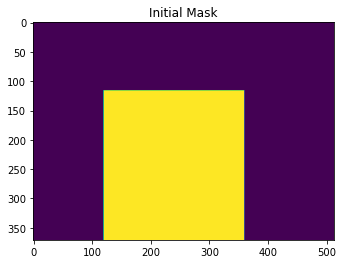

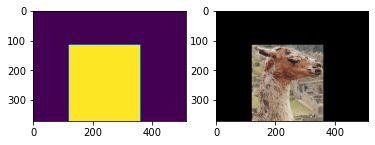

Iteration 0  20.85 seconds


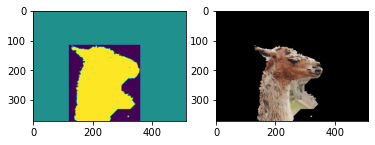

Iteration 1  23.18 seconds


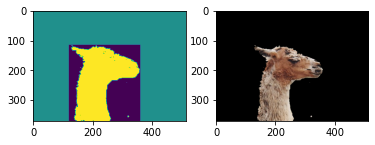

Iteration 2  21.61 seconds


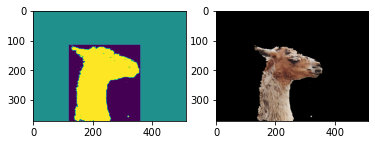

Iteration 3  22.51 seconds


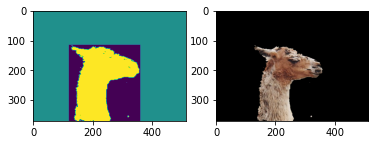

Iteration 4  25.05 seconds


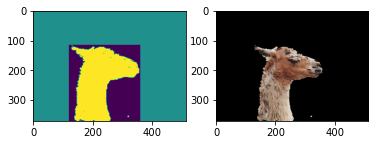

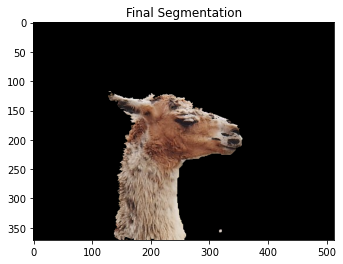

In [19]:
filename = '../images/llama.jpg'
# try:
run(filename)
# except:
# print("Error!")
cv2.destroyAllWindows()

# Sheep

176 179 122 206


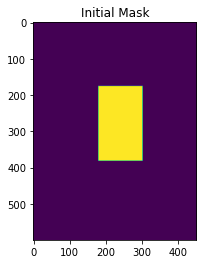

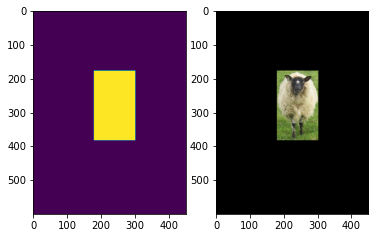

Iteration 0  23.35 seconds


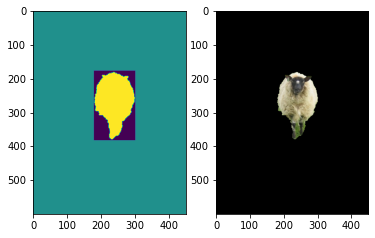

Iteration 1  23.19 seconds


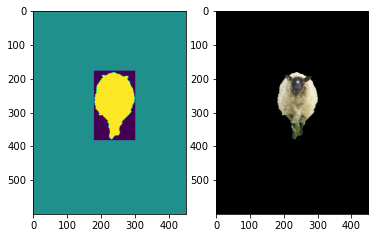

Iteration 2  22.5 seconds


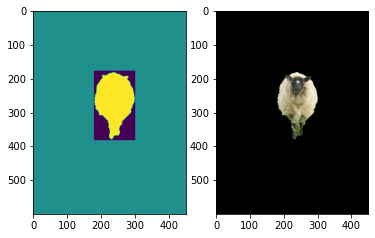

Iteration 3  21.49 seconds


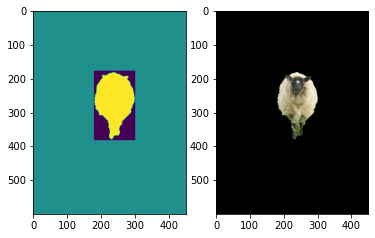

Iteration 4  21.93 seconds


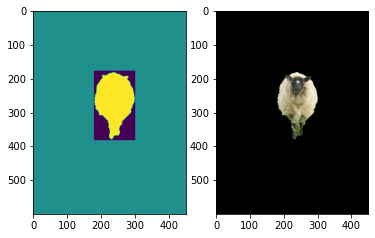

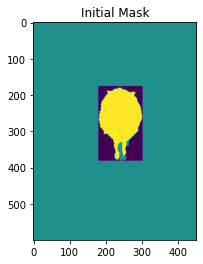

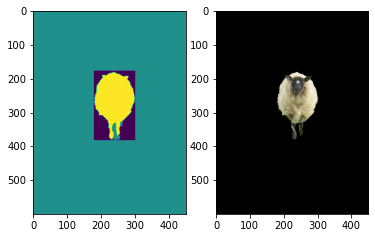

Iteration 0  24.11 seconds


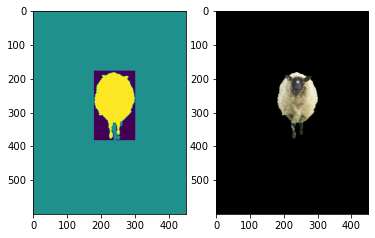

Iteration 1  22.61 seconds


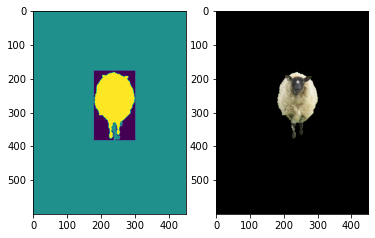

Iteration 2  22.32 seconds


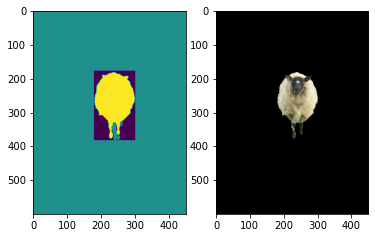

Iteration 3  23.55 seconds


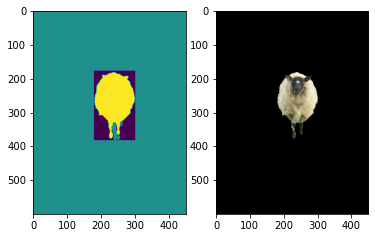

Iteration 4  21.78 seconds


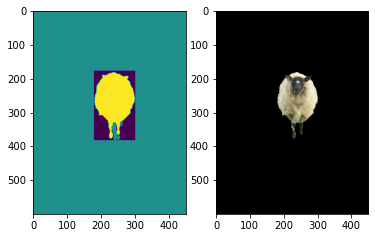

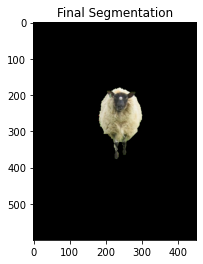

In [20]:
filename = '../images/sheep.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()

# "Elefant"

41 77 429 411


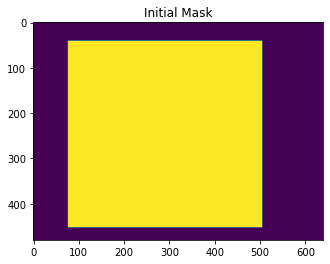

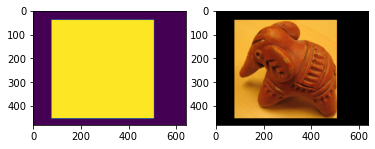

Iteration 0  36.2 seconds


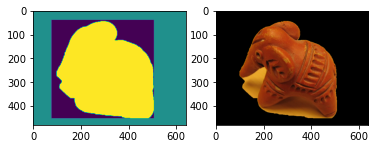

Iteration 1  23.26 seconds


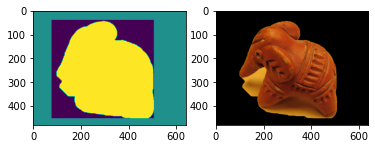

Iteration 2  24.77 seconds


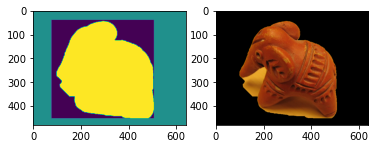

Iteration 3  24.1 seconds


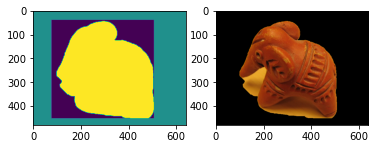

Iteration 4  26.78 seconds


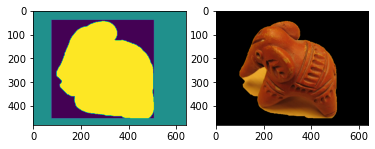

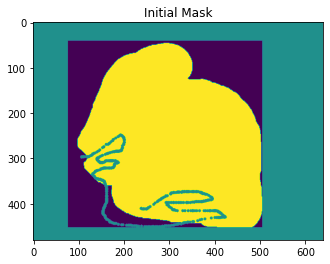

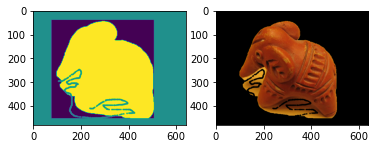

Iteration 0  27.29 seconds


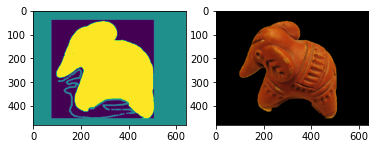

Iteration 1  37.05 seconds


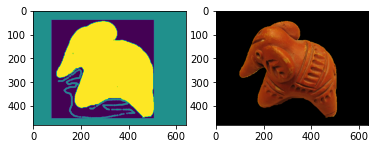

Iteration 2  22.74 seconds


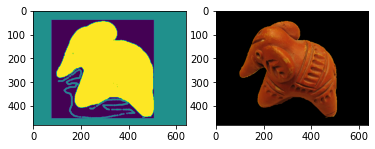

Iteration 3  28.75 seconds


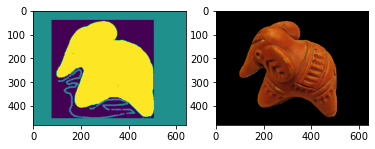

Iteration 4  24.04 seconds


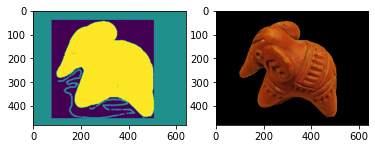

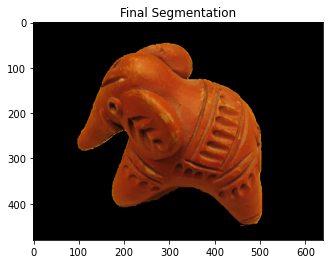

In [21]:
filename = '../images/elefant.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()

# Study

## Number of Iterations

We saw performance with 5 iterations previously. Here, we use 2 iterations. We notice that it is largely identitcal to the earlier case. Here, some of the finer details are not captured however. Some of the details like near the ear or near the neck are more refined. This is visible in the iteration development in previous runs as well.

![two iter](./report/llama_two.png)

109 89 297 270


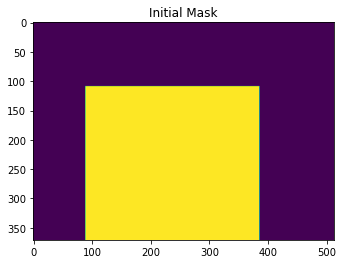

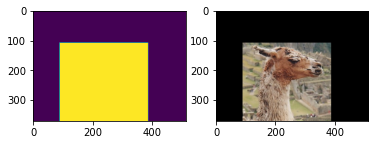

Iteration 0  22.81 seconds


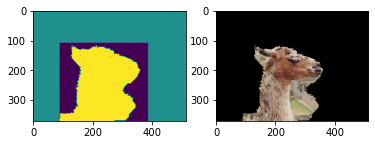

Iteration 1  23.21 seconds


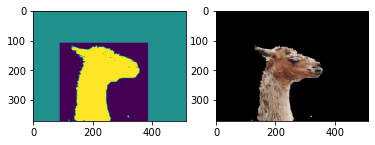

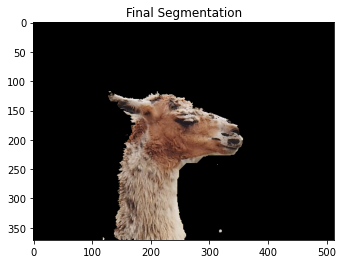

In [33]:
filename = '../images/llama.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()

# Bounding Box Impact

The bounding box determines the colour distribution of the foreground and background. Naturally, this can lead to a misleading colour distribution which leads to an incorrect segmentation. This is verified using a run of grabcut with a very loose bounding box. Notice how the image below ignores some of the hilly region, since it is heavily featured in the bounding box.

![Llama moo](./report/llama_loose_segmented.png)

28 15 374 362


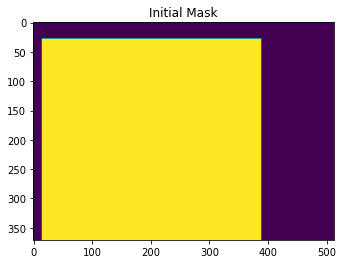

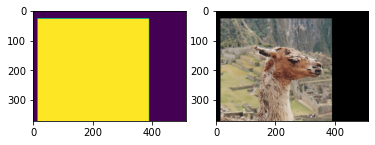

Iteration 0  22.16 seconds


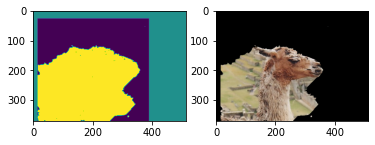

Iteration 1  18.61 seconds


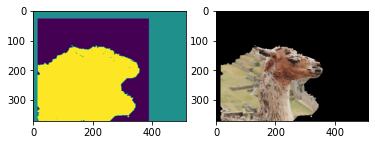

Iteration 2  21.79 seconds


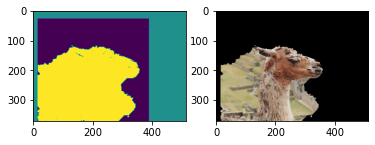

Iteration 3  23.22 seconds


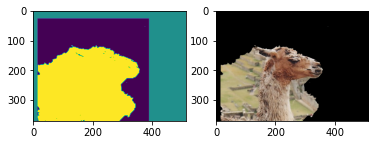

Iteration 4  22.55 seconds


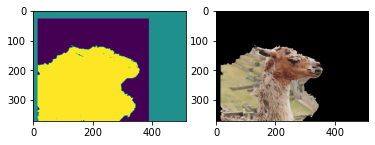

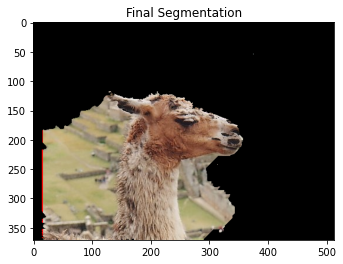

In [22]:
filename = '../images/llama.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()

# Gamma

The gamma value is used in the smoothness term. It largely determines the degree of smoothness. Hence, a lower value doesn't encourage smoothness across pixel neighbours. This is experimentally validated as a low gamma ($\gamma=1$) leads to a segmentation with several patches. On the other hand, a very high gamma (300 in the second image) aggressively cuts into the foreground.

![Low Gamma](./report/low_gamma.png)

![High Gamma](./report/llama_300.png)

110 114 255 275


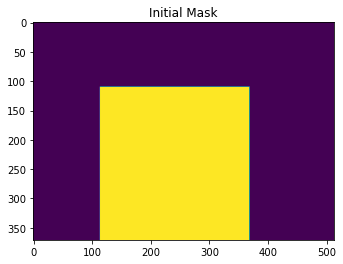

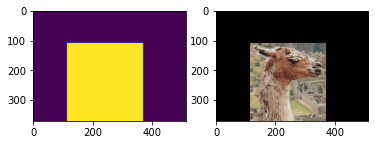

Iteration 0  29.02 seconds


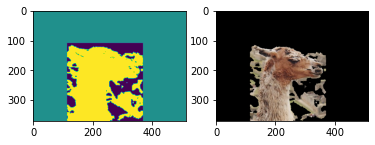

Iteration 1  22.33 seconds


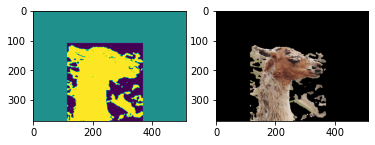

Iteration 2  21.2 seconds


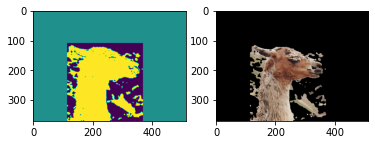

Iteration 3  20.98 seconds


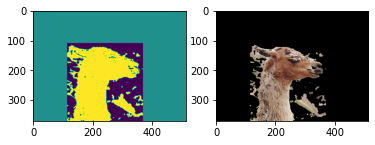

Iteration 4  21.4 seconds


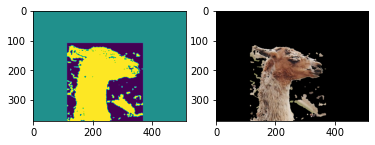

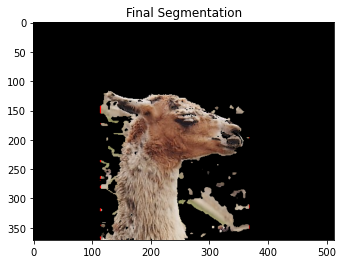

In [24]:
filename = '../images/llama.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()

110 114 247 268


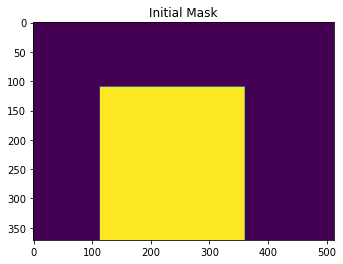

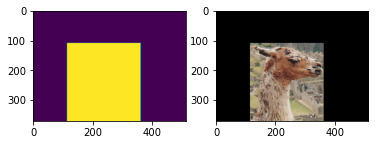

Iteration 0  26.77 seconds


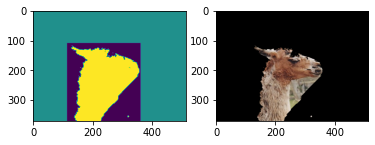

Iteration 1  33.7 seconds


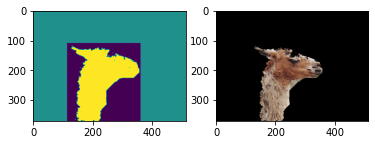

Iteration 2  38.24 seconds


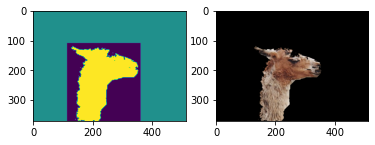

Iteration 3  25.59 seconds


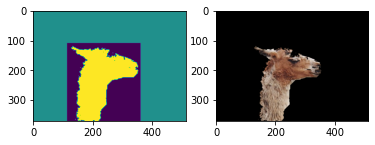

Iteration 4  28.2 seconds


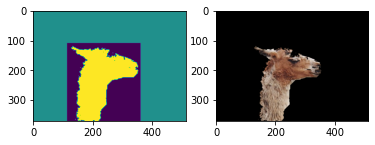

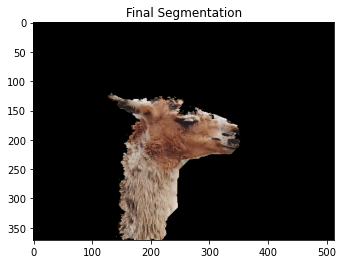

In [37]:
filename = '../images/llama.jpg'
try:
    run(filename)
except:
    print("Error!")
cv2.destroyAllWindows()